In this file we explore the dataset without any alteration

# Imports and Configurations

In [34]:
import torch
import torchvision
import torchvision.transforms as transforms

import torchinfo

import kornia

import matplotlib.pyplot as plt
import numpy as np
import time

import os
import pathlib
from PIL import Image
import skimage
from tqdm import tqdm

# importing a module with utilities for displaying stats and data
import sys
sys.path.insert(1, '../util')
import vcpi_util

In [35]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [36]:
# Paths
pathTrain = '../train_images/GTSRB/Final_Training/Images'
pathTest = '../test_images'

# Batch size - It can influence speed and generalization, not necessarily in the same direction. 
# There is no golden rule for the batch size but 32 is a commom number to start with.
BATCH_SIZE = 32

IMAGE_SIZE = 32
EPOCHS = 40

# Auxiliary Functions

In [37]:
def evaluate(model, data_loader):

    # sets the model in evaluation mode.
    # although our model does not have layers which behave differently during training and evaluation
    # this is a good practice as the models architecture may change in the future
    model.eval()

    correct = 0
    
    for i, (images, targets) in enumerate(data_loader):
         
        # forward pass, compute the output of the model for the current batch
        outputs = model(images.to(device))

        # "max" returns a namedtuple (values, indices) where values is the maximum 
        # value of each row of the input tensor in the given dimension dim; 
        # indices is the index location of each maximum value found (argmax).
        # the argmax effectively provides the predicted class number        
        _, preds = torch.max(outputs, dim=1)

        correct += (preds.cpu() == targets).sum()

    return (correct / len(data_loader.dataset)).item()

In [38]:
from skimage.util import random_noise

class RandomMotionBlur:
    def __init__(self, kernel_size=9, angle=180.0, direction=-0.5, p=0.5):
        self.kernel_size = kernel_size
        self.angle = angle
        self.direction = direction
        self.p = p

    def __call__(self, img):
        # Normalize to [0, 1]
        img = img.float() / 255.0

        if torch.rand(1) < self.p:
            img = kornia.filters.motion_blur(img.unsqueeze(0), self.kernel_size, self.angle, self.direction)
            return img.squeeze(0)
        else:
            return img
        
class Noise:
    def __init__(self, mean=0, var=0.05, p=0.5):
        self.mean = mean
        self.var = var
        self.p = p

    def __call__(self, img):
        if torch.rand(1) < self.p:
            noisy_img = torch.tensor(random_noise(img, mode='speckle', mean=self.mean, var=self.var, clip=True))
            return noisy_img
        else:
            return img

# Prepare and Load Data

In [39]:
# Convert the images from ppm to png
from PIL import Image
import glob
def ppm2png():
    images = glob.glob(f'{pathTrain}/**/*.ppm',recursive=True)
    for image in images:
        im = Image.open(image)
        new_filename = image[:-4] + '.png'
        im.save(new_filename)
        if image.endswith('.ppm'):
            os.remove(image)

    images = glob.glob(f'{pathTest}/**/*.ppm',recursive=True)
    for image in images:
        im = Image.open(image)
        new_filename = image[:-4] + '.png'
        im.save(new_filename)
        if image.endswith('.ppm'):
            os.remove(image)
#ppm2png()

At this point we should apply transformations to our dataset

In [40]:
from torchvision.transforms import v2

transform_train = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.RandomAutocontrast(p=1.0),                      # Apply autocontrast to the image
    v2.RandomRotation(15),                             # Will rotate the image randomly by an angle of -15 to 15 degrees
    v2.RandomPerspective(distortion_scale=0.5, p=0.3), # Apply a random perspective transformation to the image
    v2.ToImage(),                                      # Convert to tensor
    v2.ToDtype(torch.float32, scale=True)              # Normalize to [0,1]
])

transform_test = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.RandomAutocontrast(p=1.0),          # Apply autocontrast to the image
    v2.ToImage(),                          # Convert to tensor
    v2.ToDtype(torch.float32, scale=True)  # Normalize to [0,1]
])

In [41]:
new_transform_train = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.ColorJitter(brightness=0.5),        # Randomly change the brightness image by a factor of 0.3 (0.7 to 1.3)
    v2.RandomCrop(IMAGE_SIZE, padding=4),  # Crop the image to a random size of (32, 32)
    v2.RandomErasing(p=0.4, scale=(0.02, 0.10), value='random'), # Randomly erase the image
    v2.ToImage(),                          # Convert to tensor
    v2.ToDtype(torch.float32, scale=True)  # Normalize to [0,1]
])

In [42]:
new_transform_train_2 = v2.Compose([
    v2.Resize((IMAGE_SIZE, IMAGE_SIZE)),
    v2.RandomAutocontrast(p=1.0),          # Apply autocontrast to the image
    v2.ToImage(),                          # Convert to tensor
    Noise(var=0.01,p=0.4),
    RandomMotionBlur(kernel_size=7,p=0.3), # Apply motion blur with a given probability
    v2.ToDtype(torch.float32, scale=True)  # Normalize to [0,1]
])

In [43]:
new_train_set = torchvision.datasets.ImageFolder(root=pathTrain, transform=new_transform_train)

In [44]:
new_train_set_2 = torchvision.datasets.ImageFolder(root=pathTrain, transform=new_transform_train_2)

In [45]:
train_set = torchvision.datasets.ImageFolder(root=pathTrain, transform=transform_train)

In [46]:
increased_dataset = torch.utils.data.ConcatDataset([train_set, new_train_set, new_train_set_2])

In [47]:
train_loader = torch.utils.data.DataLoader(increased_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_set = torchvision.datasets.ImageFolder(root=pathTest, transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE)

In [48]:
increased_dataset.datasets[0].classes

['00000',
 '00001',
 '00002',
 '00003',
 '00004',
 '00005',
 '00006',
 '00007',
 '00008',
 '00009',
 '00010',
 '00011',
 '00012',
 '00013',
 '00014',
 '00015',
 '00016',
 '00017',
 '00018',
 '00019',
 '00020',
 '00021',
 '00022',
 '00023',
 '00024',
 '00025',
 '00026',
 '00027',
 '00028',
 '00029',
 '00030',
 '00031',
 '00032',
 '00033',
 '00034',
 '00035',
 '00036',
 '00037',
 '00038',
 '00039',
 '00040',
 '00041',
 '00042']

In [49]:
test_set.classes

['00000',
 '00001',
 '00002',
 '00003',
 '00004',
 '00005',
 '00006',
 '00007',
 '00008',
 '00009',
 '00010',
 '00011',
 '00012',
 '00013',
 '00014',
 '00015',
 '00016',
 '00017',
 '00018',
 '00019',
 '00020',
 '00021',
 '00022',
 '00023',
 '00024',
 '00025',
 '00026',
 '00027',
 '00028',
 '00029',
 '00030',
 '00031',
 '00032',
 '00033',
 '00034',
 '00035',
 '00036',
 '00037',
 '00038',
 '00039',
 '00040',
 '00041',
 '00042']

In [50]:
# Print the number of images in each class of the training set
for i, c in enumerate(increased_dataset.datasets[0].classes):
    print(f'{c}: {len(os.listdir(os.path.join(pathTrain, c)))}')
print(f'Total: {len(increased_dataset)}')

00000: 211
00001: 2221
00002: 2251
00003: 1411
00004: 1981
00005: 1861
00006: 421
00007: 1441
00008: 1411
00009: 1471
00010: 2011
00011: 1321
00012: 2101
00013: 2161
00014: 781
00015: 631
00016: 421
00017: 1111
00018: 1201
00019: 211
00020: 361
00021: 331
00022: 391
00023: 511
00024: 271
00025: 1501
00026: 601
00027: 241
00028: 541
00029: 271
00030: 451
00031: 781
00032: 241
00033: 690
00034: 421
00035: 1201
00036: 391
00037: 211
00038: 2071
00039: 301
00040: 361
00041: 241
00042: 241
Total: 117627


In [51]:
# Print the number of images in each class of the test set
for i, c in enumerate(test_set.classes):
    print(f'{c}: {len(os.listdir(os.path.join(pathTest, c)))}')
print(f'Total: {len(test_set)}')

00000: 60
00001: 720
00002: 750
00003: 450
00004: 660
00005: 630
00006: 150
00007: 450
00008: 450
00009: 480
00010: 660
00011: 420
00012: 690
00013: 720
00014: 270
00015: 210
00016: 150
00017: 360
00018: 390
00019: 60
00020: 90
00021: 90
00022: 120
00023: 150
00024: 90
00025: 480
00026: 180
00027: 60
00028: 150
00029: 90
00030: 150
00031: 270
00032: 60
00033: 210
00034: 120
00035: 390
00036: 120
00037: 60
00038: 690
00039: 90
00040: 90
00041: 60
00042: 90
Total: 12630


In [52]:
images, targets = next(iter(train_loader))
print("Batch shape: ", images.shape) # [batch_size, channels, height, width]
print(targets) 

Batch shape:  torch.Size([32, 3, 32, 32])
tensor([35, 38,  7,  0, 12, 24,  8, 35,  8, 26, 41, 38,  5, 24, 35,  1, 30, 25,
         3, 14, 15, 10, 16, 24, 18, 12, 14, 33, 13,  1,  3, 31])


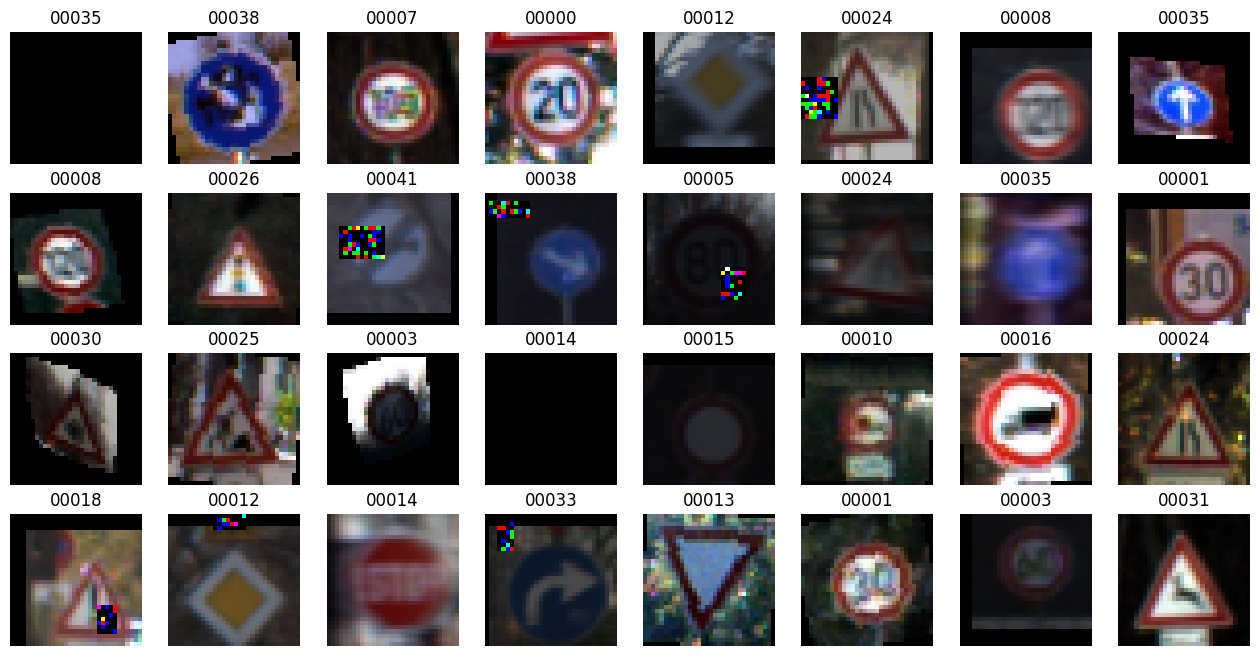

<Figure size 640x480 with 0 Axes>

In [53]:
vcpi_util.show_images(4,8,images, targets, increased_dataset.datasets[0].classes)

# Treino

In [54]:
class Conv(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv1 = torch.nn.Conv2d(3, 16, 3) # 3 canais de entrada (porque as imagens são cores), 16 canais de saída, kernel 3x3  
        self.bn1 = torch.nn.BatchNorm2d(16)    
        self.relu1 = torch.nn.ReLU()

        self.conv2 = torch.nn.Conv2d(16, 32, 3)
        self.bn2 = torch.nn.BatchNorm2d(32)
        self.relu2 = torch.nn.ReLU()

        self.maxpool1 = torch.nn.MaxPool2d(2)   # kernel 2x2, a imagem é reduzida para metade

        self.conv3 = torch.nn.Conv2d(32, 48, 3)
        self.bn3 = torch.nn.BatchNorm2d(48)        
        self.relu3 = torch.nn.ReLU()

        self.conv4 = torch.nn.Conv2d(48, 48, 3)
        self.bn4 = torch.nn.BatchNorm2d(48)
        self.relu4 = torch.nn.ReLU()

        self.maxpool2 = torch.nn.MaxPool2d(2)  # kernel 2x2, a imagem é novamente reduzida para metade

        self.fc1 = torch.nn.Linear(1200,num_classes) 

    def forward(self, x):
        # input = (batch_size, 3, 32, 32)
        x = self.conv1(x)                  # output = (batch_size, 16, 30, 30)  
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)                  # output = (batch_size, 32, 28, 28)
        x = self.bn2(x)
        x = self.relu2(x)

        x = self.maxpool1(x)               # output = (batch_size, 32, 14, 14)

        x = self.conv3(x)                  # output = (batch_size, 48, 12, 12)                     
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)                  # output = (batch_size, 48, 10, 10)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.maxpool2(x)               # output = (batch_size, 48, 5, 5)     45 x 5 x 5 = 1200

        x = torch.flatten(x, 1)             
        x = self.fc1(x)                                                                                     

        return x 
    
model_I = Conv(len(increased_dataset.datasets[0].classes))
model_I.to(device)
print(model_I)

torchinfo.summary(model_I, input_size=(BATCH_SIZE, 3, IMAGE_SIZE, IMAGE_SIZE))

Conv(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 48, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1200, out_features=43, bias=True)
)


Layer (type:depth-idx)                   Output Shape              Param #
Conv                                     [32, 43]                  --
├─Conv2d: 1-1                            [32, 16, 30, 30]          448
├─BatchNorm2d: 1-2                       [32, 16, 30, 30]          32
├─ReLU: 1-3                              [32, 16, 30, 30]          --
├─Conv2d: 1-4                            [32, 32, 28, 28]          4,640
├─BatchNorm2d: 1-5                       [32, 32, 28, 28]          64
├─ReLU: 1-6                              [32, 32, 28, 28]          --
├─MaxPool2d: 1-7                         [32, 32, 14, 14]          --
├─Conv2d: 1-8                            [32, 48, 12, 12]          13,872
├─BatchNorm2d: 1-9                       [32, 48, 12, 12]          96
├─ReLU: 1-10                             [32, 48, 12, 12]          --
├─Conv2d: 1-11                           [32, 48, 10, 10]          20,784
├─BatchNorm2d: 1-12                      [32, 48, 10, 10]          96
├─R

With Early Stopping

In [55]:
class Early_Stopping():

    def __init__(self, patience = 3, min_delta = 0.00001):
        self.patience = patience 
        self.min_delta = min_delta

        self.min_delta
        self.min_val_loss = float('inf')

    def __call__(self, val_loss):
        # improvement
        if val_loss + self.min_delta < self.min_val_loss:
            self.min_val_loss = val_loss
            self.counter = 0

        # no improvement            
        else:
            self.counter += 1
            if self.counter > self.patience:
                return True
            
        return False

In [56]:
def train(model, train_loader, test_loader, epochs, loss_fn, optimizer, early_stopper):
    history = {}
    history['accuracy'] = []
    #history['val_acc'] = []
    #history['val_loss'] = []
    history['test_acc'] = []
    history['test_loss'] = []
    history['loss'] = []
    best_val_loss = np.inf

    for epoch in range(epochs):  # loop over the dataset multiple times

        model.train()
        start_time = time.time() 
        correct = 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(train_loader, 0):
            
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            loss = loss_fn(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss
            correct += (predicted == targets).sum()

        model.eval()
        with torch.no_grad():
            t_correct = 0
            test_loss = 0.0            
            for i,t in test_loader:
                i, t = i.to(device), t.to(device)
                o = model(i)
                _,p = torch.max(o,1)
                
                test_loss += loss_fn(o, t)

                t_correct += (p == t).sum()

        old_lr = optimizer.param_groups[0]['lr']
        #scheduler.step(val_loss)
        new_lr = optimizer.param_groups[0]['lr']
        
        if old_lr != new_lr:
            print('==> Learning rate updated: ', old_lr, ' -> ', new_lr)

        epoch_loss = running_loss / len(train_loader.dataset)
        accuracy = 100 * correct / len(train_loader.dataset)
        t_accuracy = 100 * t_correct / len(test_loader.dataset)
        test_loss = test_loss / len(test_loader.dataset)
        stop_time = time.time()
        print(f'Epoch: {epoch:03d}; Loss: {epoch_loss:0.6f}; Accuracy: {accuracy:0.4f}; Test Acc: {t_accuracy:0.4f}; Elapsed time: {(stop_time - start_time):0.4f}')
        history['accuracy'].append(accuracy.cpu().numpy())
        history['test_acc'].append(t_accuracy.cpu().numpy())
        history['test_loss'].append(test_loss.cpu().detach().numpy())
        history['loss'].append(epoch_loss.cpu().detach().numpy())
 
        ###### Saving ######
        '''if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                'epoch': epoch,
                'model':model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict()
                },
                f'{save_prefix}_{epoch}.pt')'''

        if early_stopper(test_loss):
            print('Early stopping!')
            break
        
    print('Finished Training')

    return(history)

In [57]:
optimizer_I = torch.optim.Adam(model_I.parameters())
loss_fn = torch.nn.CrossEntropyLoss()

early_stop = Early_Stopping(10)

history_I = train(model_I,train_loader,test_loader,EPOCHS,loss_fn,optimizer_I,early_stop)

Epoch: 000; Loss: 0.028049; Accuracy: 75.2735; Test Acc: 97.2051; Elapsed time: 152.6946
Epoch: 001; Loss: 0.016262; Accuracy: 86.0134; Test Acc: 97.8622; Elapsed time: 178.8104
Epoch: 002; Loss: 0.009013; Accuracy: 91.8837; Test Acc: 98.7490; Elapsed time: 145.0279
Epoch: 003; Loss: 0.006542; Accuracy: 94.1918; Test Acc: 98.5432; Elapsed time: 194.4465
Epoch: 004; Loss: 0.005328; Accuracy: 95.1950; Test Acc: 98.5827; Elapsed time: 146.9063
Epoch: 005; Loss: 0.004768; Accuracy: 95.7136; Test Acc: 98.3690; Elapsed time: 146.3216
Epoch: 006; Loss: 0.004132; Accuracy: 96.3316; Test Acc: 98.5986; Elapsed time: 2689.7111
Epoch: 007; Loss: 0.003870; Accuracy: 96.4762; Test Acc: 98.9865; Elapsed time: 145.1865
Epoch: 008; Loss: 0.003643; Accuracy: 96.6895; Test Acc: 99.0261; Elapsed time: 153.3751
Epoch: 009; Loss: 0.003339; Accuracy: 96.9463; Test Acc: 99.2003; Elapsed time: 153.9655
Epoch: 010; Loss: 0.003200; Accuracy: 97.0602; Test Acc: 99.0261; Elapsed time: 3005.2013
Epoch: 011; Loss: 0

# Análise dos Resultados

Although it may coincide, the best epoch considering training data accuracy is not always the best epoch for test data accuracy

In [58]:
best_train = np.asarray(history_I['accuracy']).argmax()
best_test = np.asarray(history_I['test_acc']).argmax()

print('Best epoch for train accuracy:', best_train,' Best epoch for test accuracy:',  best_test)
print('Test accuracy at epoch ',best_train, ' :', history_I['test_acc'][best_train], 'Test accuracy at epoch ',best_test, ' :', history_I['test_acc'][best_test])

Best epoch for train accuracy: 22  Best epoch for test accuracy: 11
Test accuracy at epoch  22  : 99.0578 Test accuracy at epoch  11  : 99.326996


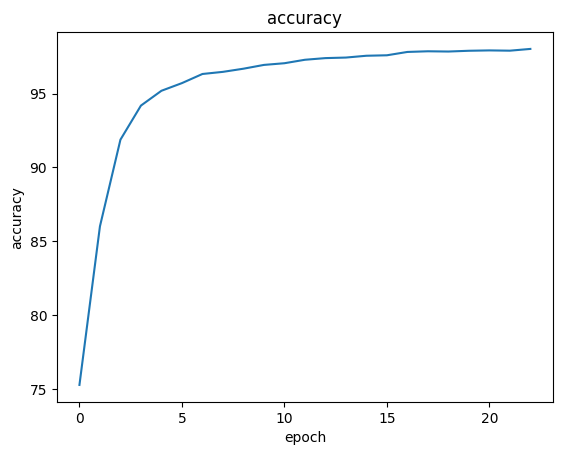

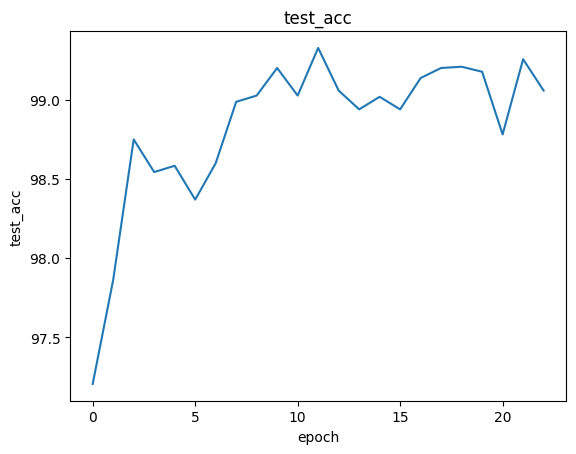

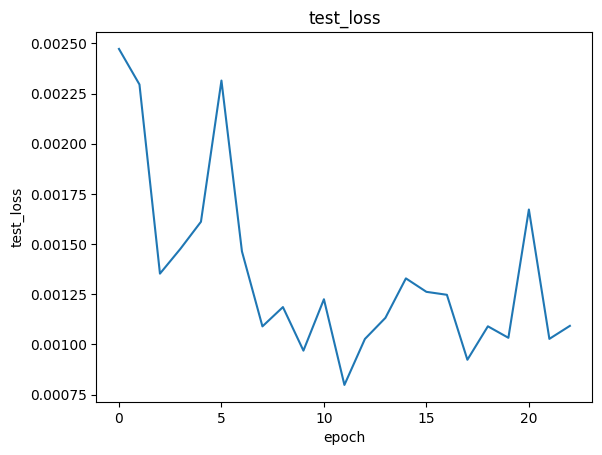

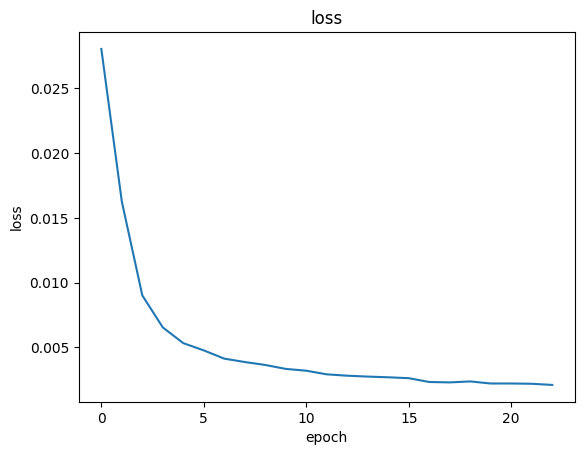

In [59]:
vcpi_util.show_history(history_I)

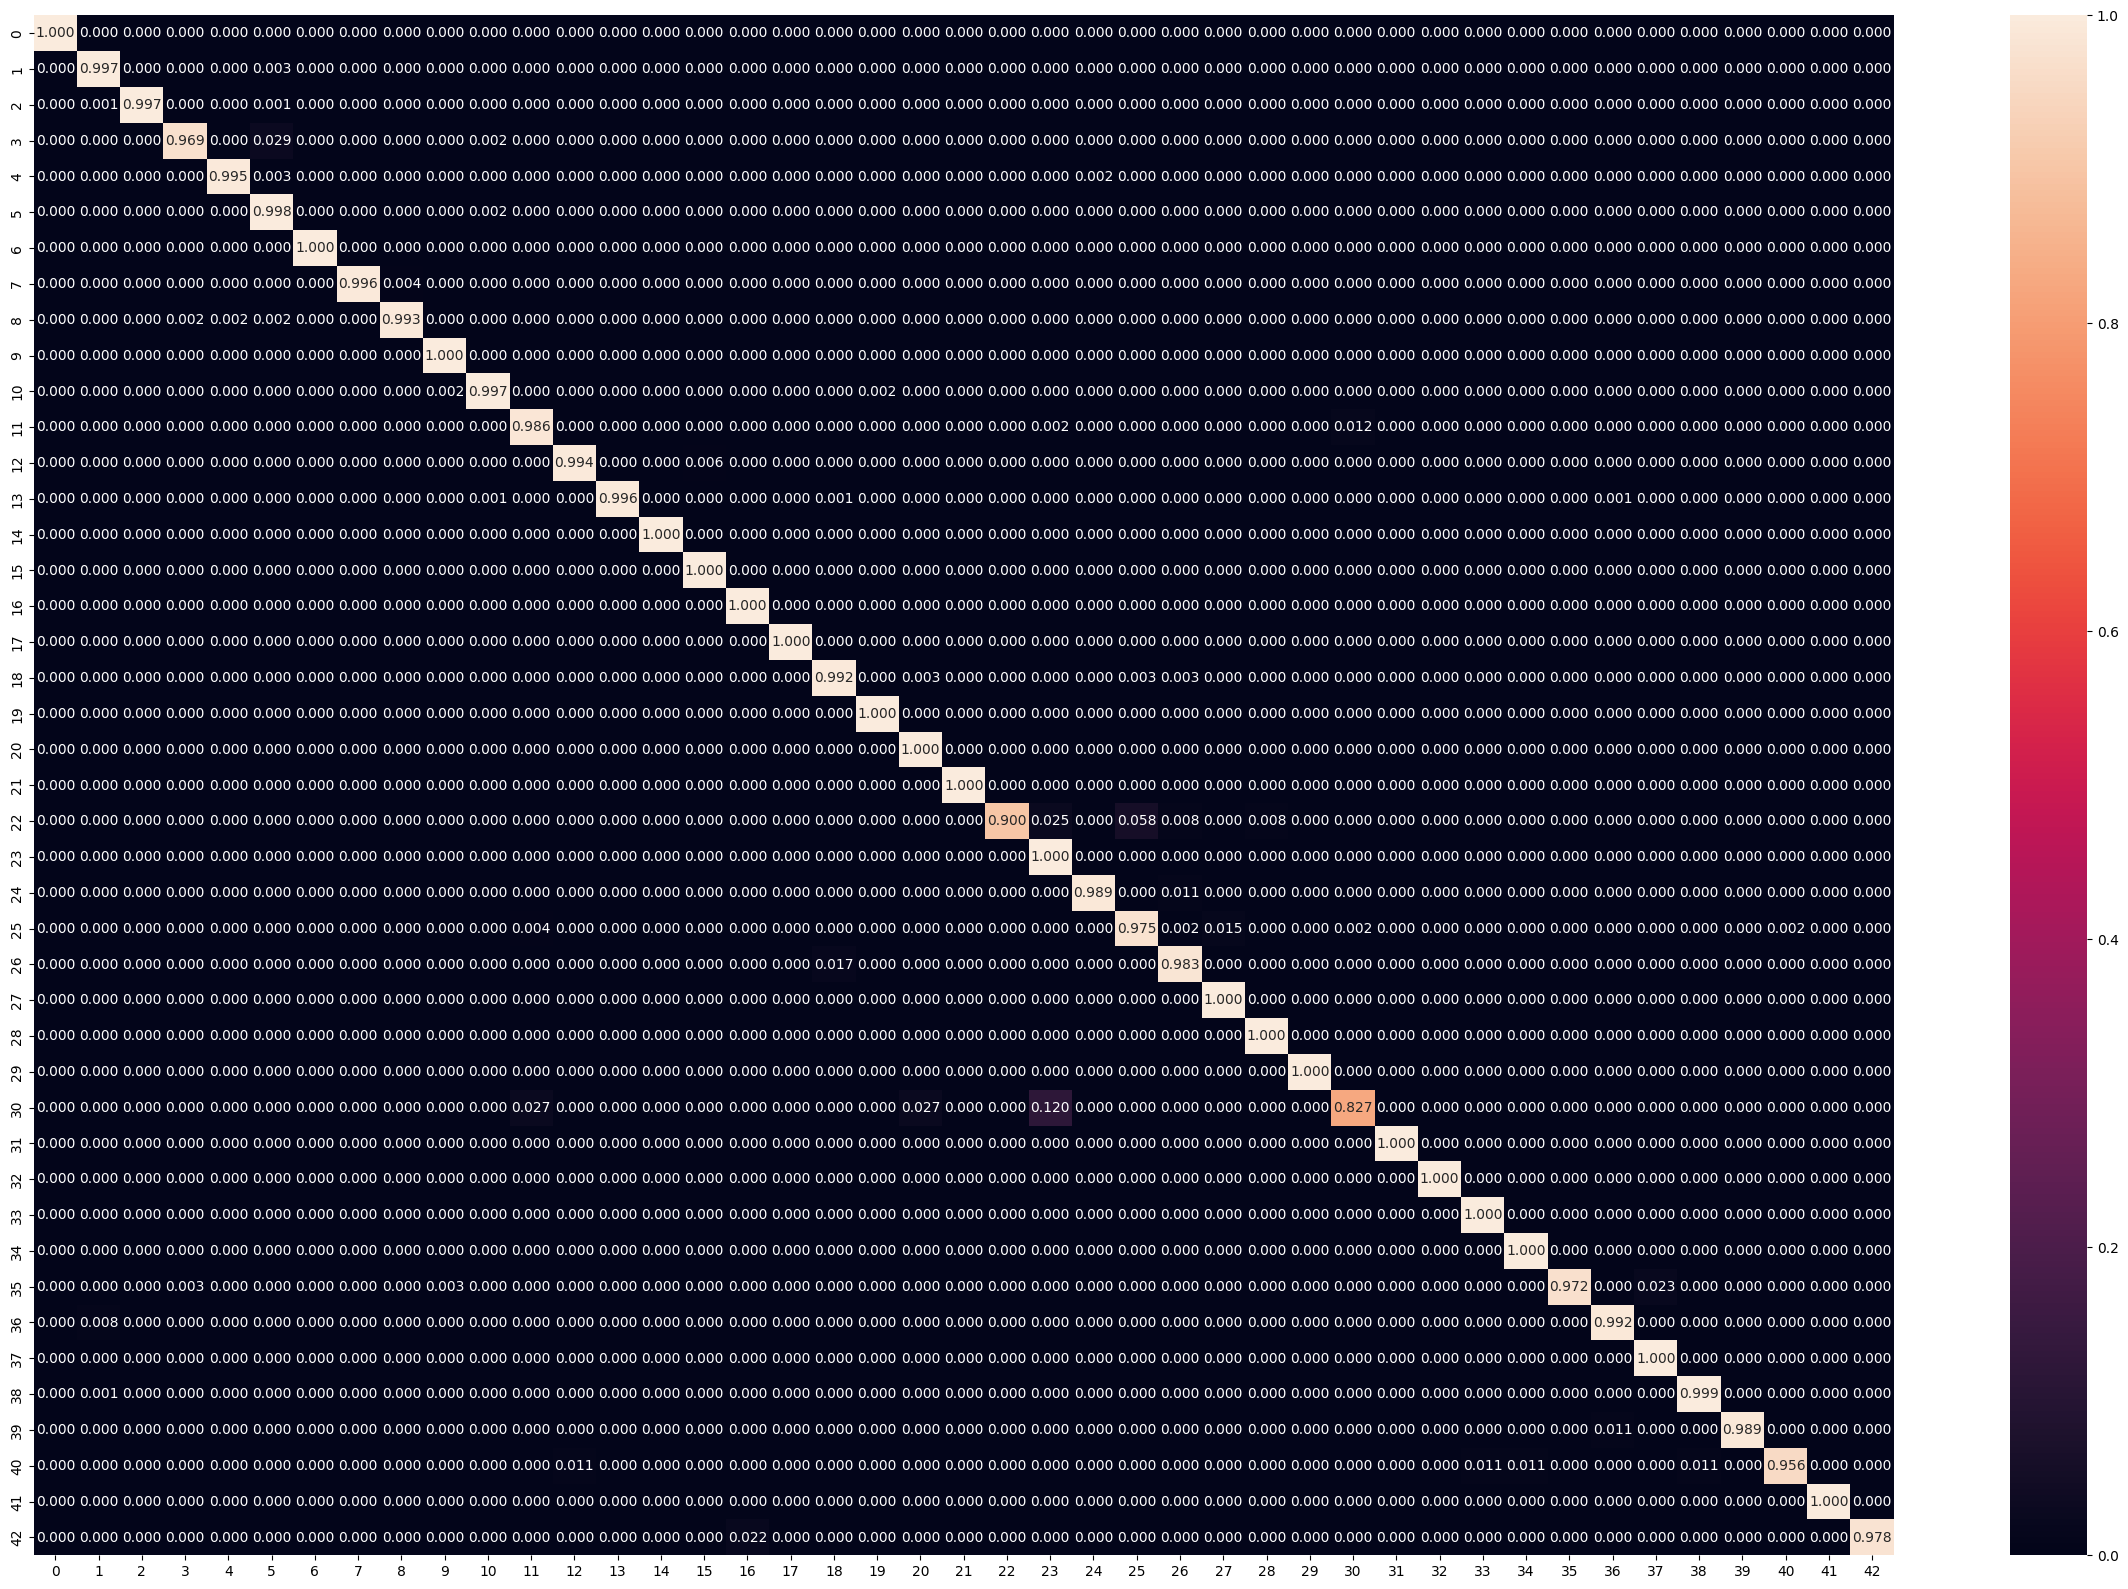

In [60]:
preds = []
ground_truth = []

for images, targets in test_loader:
    logits = model_I(images.to(device))
    preds_aux = [np.argmax(x) for x in logits.cpu().detach().numpy()]
    preds.extend(preds_aux) 
    ground_truth.extend(targets.numpy())

vcpi_util.show_confusion_matrix(ground_truth, preds, len(train_set.class_to_idx))

- From the confusion matrix, built from the predictions on the test set, we can see that regarding accuracy, not all classes behave the same way.
- The histogram presented below shows that the classes 0 are severely under represented, so that might justify its bad performance.

Counter({2: 6750, 1: 6660, 13: 6480, 12: 6300, 38: 6210, 10: 6030, 4: 5940, 5: 5580, 25: 4500, 9: 4410, 7: 4320, 8: 4230, 3: 4230, 11: 3960, 35: 3600, 18: 3600, 17: 3330, 31: 2340, 14: 2340, 33: 2067, 15: 1890, 26: 1800, 28: 1620, 23: 1530, 30: 1350, 34: 1260, 16: 1260, 6: 1260, 22: 1170, 36: 1170, 20: 1080, 40: 1080, 21: 990, 39: 900, 24: 810, 29: 810, 32: 720, 27: 720, 41: 720, 42: 720, 19: 630, 37: 630, 0: 630})


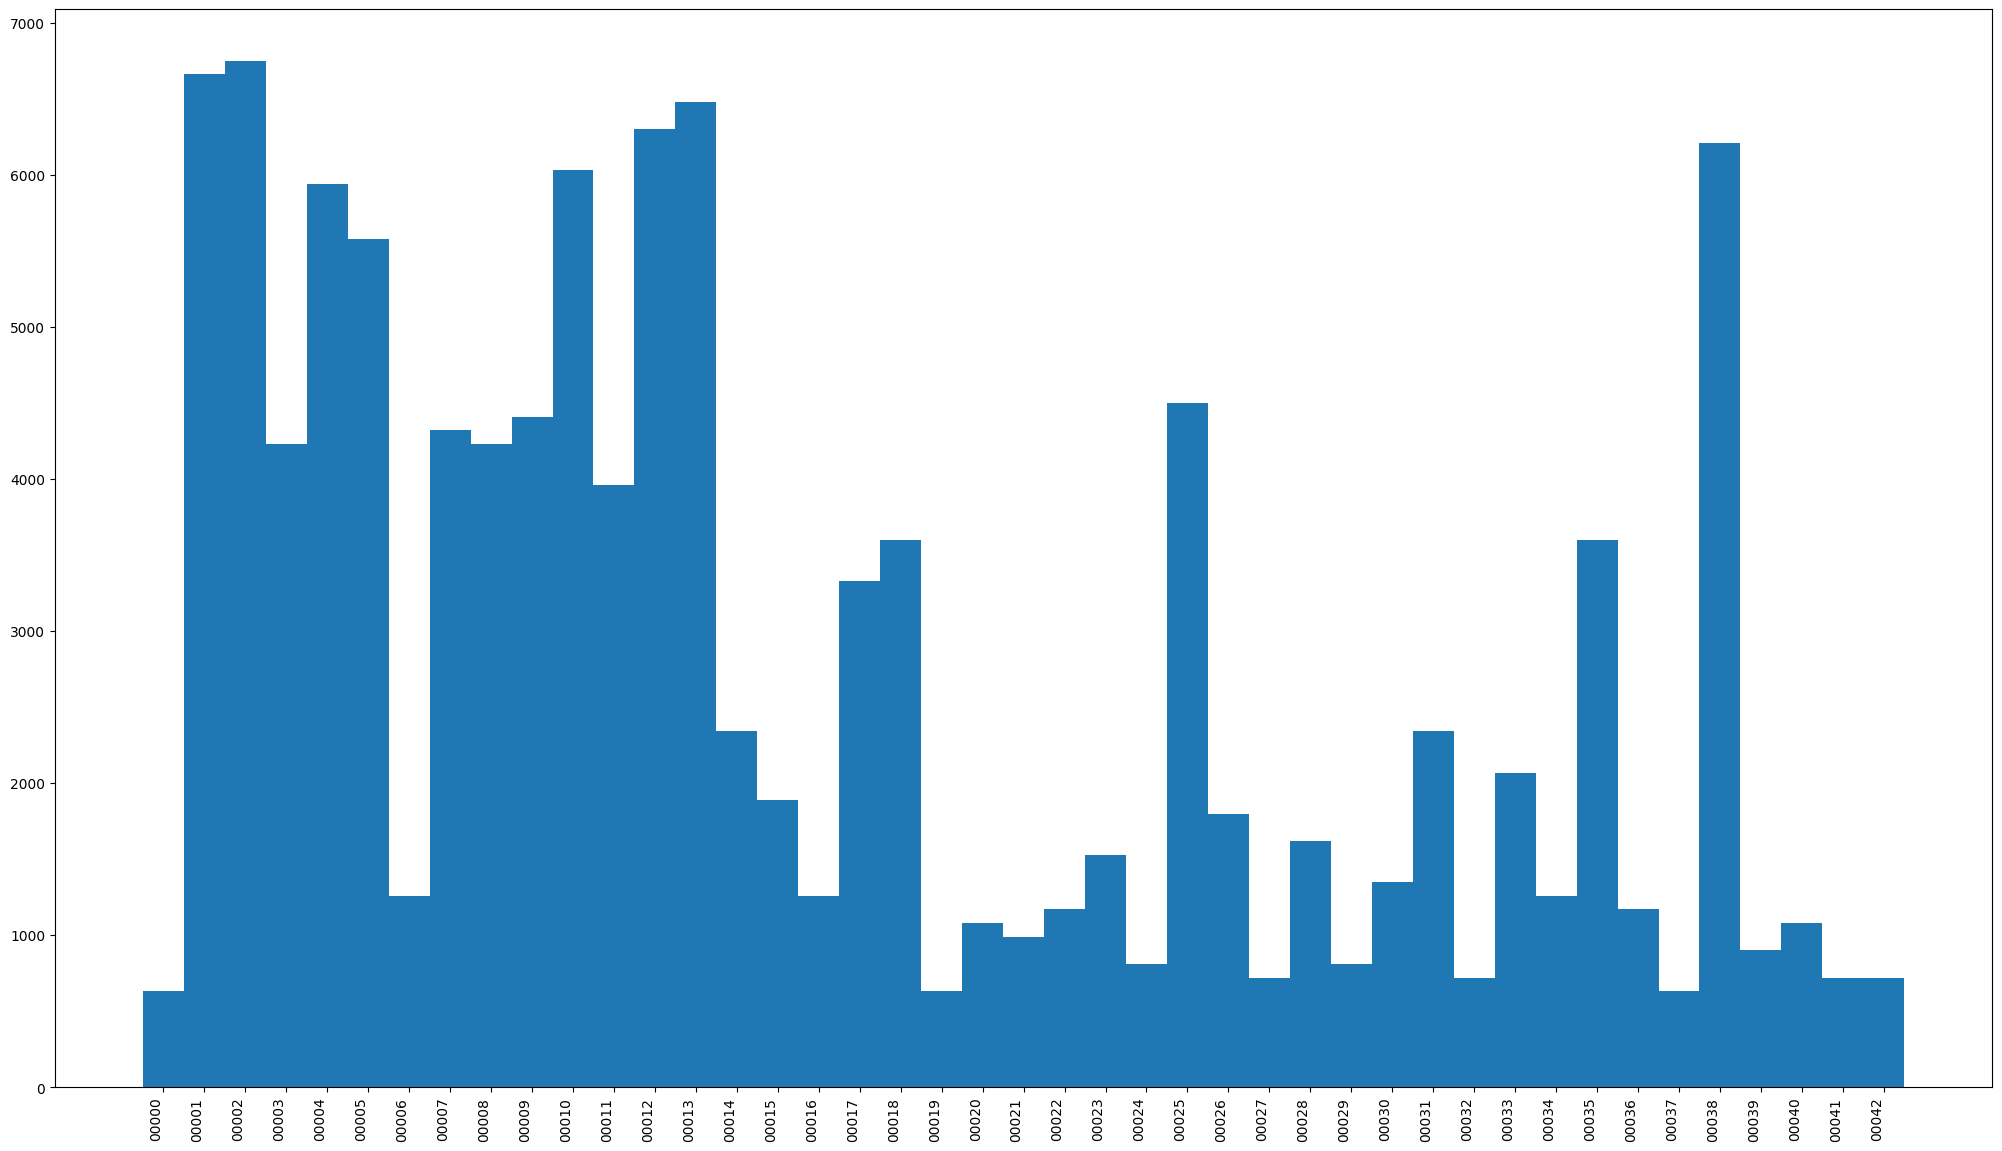

In [61]:
target_list = []

for images, targets in train_loader:
    target_list.extend(targets)

vcpi_util.show_histogram(target_list,increased_dataset.datasets[0].classes)

In [62]:
def show_bad_preds(model, dataset, classes):
    k = 0
    iters = 0

    preds = []
    ground_truth = []
    imgs = torch.Tensor(BATCH_SIZE, 3, IMAGE_SIZE,IMAGE_SIZE)

    iterator = iter(dataset)

    max_iters = test_set.__len__() / BATCH_SIZE
    while k < 32 and iters < max_iters:

        images, targets = next(iterator)
        #print(images[0].shape)
        logits = model(images.to(device))
        
        #print(predictions[0])
        predictions = torch.nn.functional.softmax(logits, dim=1).cpu().detach().numpy()
        for i in range(len(predictions)):

            if np.argmax(predictions[i]) != targets[i] and k < 32:

                preds.append(predictions[i])
                ground_truth.append(targets[i])
                imgs[k, :, :, :] = images[i]
                k += 1

        iters += 1

    vcpi_util.plot_predictions(imgs, preds, ground_truth, classes, 10, 3)

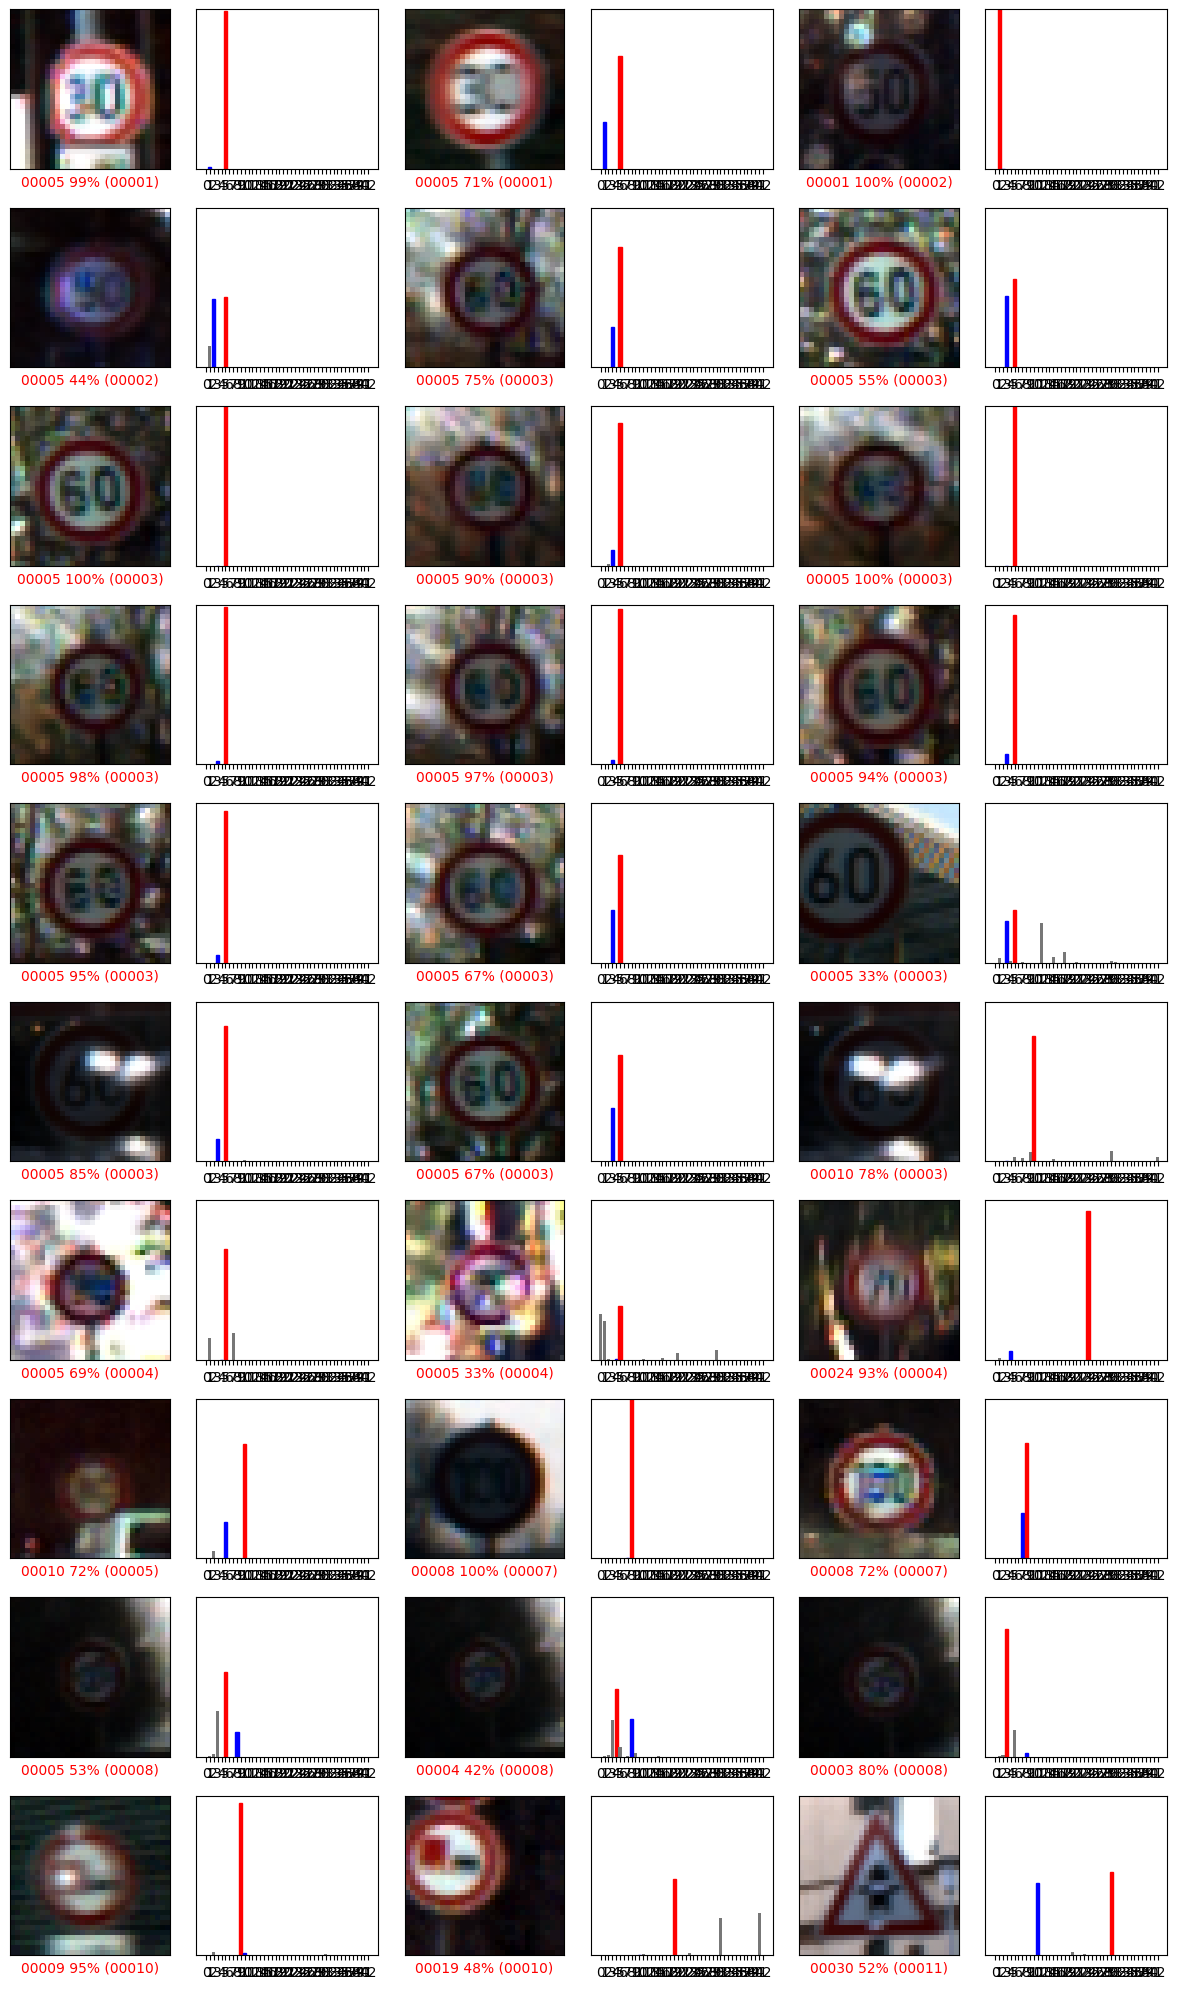

In [63]:
show_bad_preds(model_I, test_loader, test_set.classes)